In [1]:
! pip install -U statsmodels

     |████████████████████████████████| 9.5MB 5.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# color maps
from matplotlib import cm

# time series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from scipy.stats import chi2_contingency
from scipy.spatial import distance

# chi-square test
import scipy
from scipy.stats import pearsonr

## Prepare

In [3]:
# read file
url_combine_new = 'https://raw.githubusercontent.com/huahuang95/Capstone-Project/main/Datasets/new%20combine.csv?token=ARFHYYCNVJZLFVLFVVN3XBTA65FEQ'
combine_new = pd.read_csv(url_combine_new)
combine_new.head()

,Unnamed: 0,date_class,ReportDate,AssetClass,Flow_i,FlowPCT_i,AssetsEnd_i,PortfolioChangePct_i,Flow_r,FlowPCT_r,AssetsEnd_r,PortfolioChangePct_r,Flow_e,FlowPCT_e,AssetsEnd_e,PortfolioChangePct_e,ClosePct_Nasdaq,VolumePct_Nasdaq,ClosePct_Dow,VolumePct_Dow,ClosePct_Russell,VolumePct_Russell,ClosePct_SP500,VolumePct_SP500,CpiPct
0,0,2/1/2017 12:00:00 AMCommodities/Materials-Nort...,2/1/2017,Commodities/Materials-North America-USA-North ...,380.126769,4.4676,8787.631717,-1.1853,25.681524,8.0046,344.521230,-0.6207,378.578706,4.5064,8679.056347,-1.1938,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612
1,1,2/1/2017 12:00:00 AMConsumer Goods-North Ameri...,2/1/2017,Consumer Goods-North America-USA-North America...,332.526792,1.1479,28973.613060,-1.1231,-3.951259,-1.1736,329.044261,-1.0916,332.526792,1.1479,28973.613060,-1.1231,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612
2,2,2/1/2017 12:00:00 AMEnergy-North America-USA-N...,2/1/2017,Energy-North America-USA-North America-Equity,217.857886,0.3460,62136.008340,-1.6441,73.933969,0.2713,27246.540020,-0.2297,186.031374,0.3782,48446.700080,-1.8855,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612
3,3,2/1/2017 12:00:00 AMFinancials-North America-U...,2/1/2017,Financials-North America-USA-North America-Equity,999.104807,1.4776,68011.826210,-0.8896,15.229132,0.2027,7463.581982,-0.7166,968.885223,1.5139,64378.816730,-0.9202,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612
4,4,2/1/2017 12:00:00 AMHealth Care/Biotech-North ...,2/1/2017,Health Care/Biotech-North America-USA-North Am...,399.074410,1.0228,40317.775600,2.3099,-81.493857,-0.6587,12575.155820,2.2876,410.686628,1.1532,36846.852740,2.3119,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612


In [4]:
def preprocessing_new(df):
  # extract columns
  df = df[["AssetClass","ReportDate", "AssetsEnd_i","AssetsEnd_e","FlowPCT_i","PortfolioChangePct_i", "FlowPCT_e","PortfolioChangePct_e",'ClosePct_Nasdaq',	'VolumePct_Nasdaq',	'ClosePct_Dow',	'VolumePct_Dow',	'ClosePct_Russell',	'VolumePct_Russell',	'ClosePct_SP500',	'VolumePct_SP500', 'CpiPct']]
  df.rename(columns={"FlowPCT_i": "FlowPct_i", "FlowPCT_e": "FlowPct_e"}, inplace=True)
  
  # convert ReportDate to datetime 
  df['ReportDate'] = pd.to_datetime(df["ReportDate"])
  
  # extract year
  df['year'] = df['ReportDate'].dt.year

  # set ReportDate as index
  df.sort_values("ReportDate", inplace=True)
  df.set_index('ReportDate', inplace=True)
  return df

In [5]:
# trim AssetClass names
combine_new['AssetClass'] = combine_new['AssetClass'].str.replace('-North America-USA-North America-Equity', '')
combine_new = preprocessing_new(combine_new)

grouped = combine_new.groupby(combine_new['AssetClass'])
com = grouped.get_group('Commodities/Materials')
con = grouped.get_group('Consumer Goods')
ene = grouped.get_group('Energy')
fin = grouped.get_group('Financials')
hea = grouped.get_group('Health Care/Biotech')
ind = grouped.get_group('Industrials')
lcb = grouped.get_group('Large Cap Blend')
lcg = grouped.get_group('Large Cap Growth')
lcv = grouped.get_group('Large Cap Value')
mcb = grouped.get_group('Mid Cap Blend')
mcg = grouped.get_group('Mid Cap Growth')
mcv = grouped.get_group('Mid Cap Value')
rea = grouped.get_group('Real Estate')
scb = grouped.get_group('Small Cap Blend')
scg = grouped.get_group('Small Cap Growth')
scv = grouped.get_group('Small Cap Value')
tec = grouped.get_group('Technology')
tel = grouped.get_group('Telecom')
uti = grouped.get_group('Utilities')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [6]:
# winsorizing: replace outliers with the 1st and 99th percentile by year
def clipped_new(df):
  # FlowPct_i
  # loop over 2006 to 2017
  for i in range(2006, 2018):
    temp = df[df['year']==i]['FlowPct_i']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='FlowPct_i') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp]) 
  df1 = pd.DataFrame(append)
  
  # replace the original column with the winsorized one
  df.drop(columns='FlowPct_i', inplace=True)
  df = pd.concat([df, df1], axis=1)


  # repeat above steps
  # PortfolioChangePct_i
  for i in range(2006, 2018):
    temp = df[df['year']==i]['PortfolioChangePct_i']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='PortfolioChangePct_i') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='PortfolioChangePct_i', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # FlowPct_e
  for i in range(2006, 2018):
    temp = df[df['year']==i]['FlowPct_e']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='FlowPct_e') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='FlowPct_e', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # PortfolioChangePct_e
  for i in range(2006, 2018):
    temp = df[df['year']==i]['PortfolioChangePct_e']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='PortfolioChangePct_e') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='PortfolioChangePct_e', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_Nasdaq
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_Nasdaq']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_Nasdaq') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_Nasdaq', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_Nasdaq
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_Nasdaq']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_Nasdaq') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_Nasdaq', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_Dow
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_Dow']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_Dow') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_Dow', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_Dow
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_Dow']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_Dow') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_Dow', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_Russell
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_Russell']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_Russell') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_Russell', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_Russell
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_Russell']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_Russell') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_Russell', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_SP500
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_SP500']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_SP500') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_SP500', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_SP500
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_SP500']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_SP500') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_SP500', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # CpiPct
  for i in range(2006, 2018):
    temp = df[df['year']==i]['CpiPct']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='CpiPct') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='CpiPct', inplace=True)
  df = pd.concat([df, df1], axis=1)

  #AssetsEnd_i
  for i in range(2006, 2018):
    temp = df[df['year']==i]['AssetsEnd_i']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='AssetsEnd_i') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='AssetsEnd_i', inplace=True)
  df = pd.concat([df, df1], axis=1)

  #AssetsEnd_e
  for i in range(2006, 2018):
    temp = df[df['year']==i]['AssetsEnd_e']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='AssetsEnd_e') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='AssetsEnd_e', inplace=True)
  df = pd.concat([df, df1], axis=1) 
  
  return df

In [7]:
# save as dataframe with original names
com = clipped_new(com)
con = clipped_new(con)
ene = clipped_new(ene)
fin = clipped_new(fin)
hea = clipped_new(hea)
ind = clipped_new(ind)
lcb = clipped_new(lcb)
lcg = clipped_new(lcg)
lcv = clipped_new(lcv)
mcb = clipped_new(mcb)
mcg = clipped_new(mcg)
mcv = clipped_new(mcv)
rea = clipped_new(rea)
scb = clipped_new(scb)
scg = clipped_new(scg)
scv = clipped_new(scv)
tec = clipped_new(tec)
tel = clipped_new(tel)
uti = clipped_new(uti)

串流輸出內容已截斷至最後 5000 行。
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inplace=inplace)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:7358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inplace=inplace)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:7358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inp

In [8]:
com.drop(['AssetClass','year'],axis=1,inplace=True)
con.drop(['AssetClass','year'],axis=1,inplace=True)
ene.drop(['AssetClass','year'],axis=1,inplace=True)
fin.drop(['AssetClass','year'],axis=1,inplace=True)
hea.drop(['AssetClass','year'],axis=1,inplace=True)
ind.drop(['AssetClass','year'],axis=1,inplace=True)
lcb.drop(['AssetClass','year'],axis=1,inplace=True)
lcg.drop(['AssetClass','year'],axis=1,inplace=True)
lcv.drop(['AssetClass','year'],axis=1,inplace=True)
mcb.drop(['AssetClass','year'],axis=1,inplace=True)
mcg.drop(['AssetClass','year'],axis=1,inplace=True)
mcv.drop(['AssetClass','year'],axis=1,inplace=True)
rea.drop(['AssetClass','year'],axis=1,inplace=True)
scb.drop(['AssetClass','year'],axis=1,inplace=True)
scg.drop(['AssetClass','year'],axis=1,inplace=True)
scv.drop(['AssetClass','year'],axis=1,inplace=True)
tec.drop(['AssetClass','year'],axis=1,inplace=True)
tel.drop(['AssetClass','year'],axis=1,inplace=True)
uti.drop(['AssetClass','year'],axis=1,inplace=True)

### Apply moving average (windows=4)

Use moving average(set windows=4, one month) to smooth the datasets and remove the volatility. 

In [9]:
# add the AssetsEnd_e(t-1) and AssetsEnd_i(t-1) to the dataframe
def assets(df):
  df['AssetsEnd_e(t-1)'] = df['AssetsEnd_e'].shift(periods=1)
  df['AssetsEnd_i(t-1)'] = df['AssetsEnd_i'].shift(periods=1)
  return df

In [10]:
# smooth time series(set windows=4 (a month))
def rolling_avg(df):
  df = df.rolling(window=4).mean().iloc[3:,:]
  return df

In [11]:
com = rolling_avg(com)
con = rolling_avg(con)
ene = rolling_avg(ene)
fin = rolling_avg(fin)
hea = rolling_avg(hea)
ind = rolling_avg(ind)
lcb = rolling_avg(lcb)
lcg = rolling_avg(lcg)
lcv = rolling_avg(lcv)
mcb = rolling_avg(mcb)
mcg = rolling_avg(mcg)
mcv = rolling_avg(mcv)
rea = rolling_avg(rea)
scb = rolling_avg(scb)
scg = rolling_avg(scg)
scv = rolling_avg(scv)
tec = rolling_avg(tec)
tel = rolling_avg(tel)
uti = rolling_avg(uti)

In [12]:
com = assets(com)
con = assets(con)
ene = assets(ene)
fin = assets(fin)
hea = assets(hea)
ind = assets(ind)
lcb = assets(lcb)
lcg = assets(lcg)
lcv = assets(lcv)
mcb = assets(mcb)
mcg = assets(mcg)
mcv = assets(mcv)
rea = assets(rea)
scb = assets(scb)
scg = assets(scg)
scv = assets(scv)
tec = assets(tec)
tel = assets(tel)
uti = assets(uti)

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import operator

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from math import sqrt
from datetime import datetime
from datetime import timedelta

test_size = 52
time_step = 52

##### Define function - change_binary()

To better understand the directional patterns of the forecasts, we change actual and forecast values to binary numbers to detect direction. For example, if we set the threshold as 0.1 which means if the current value < last week's value - 0.1, then change the value to -1, indicating a decrease in returns; if the current value > last week's value + 0.1, then change the value to 1, indicating an increase in returns; otherwise change the value to 0.

In [14]:
def change_binary(direc, threshold=0):
  for i in range(len(direc)-1):
    if direc.loc[:, 'Actual'].iloc[i+1] < (direc.loc[:, 'Actual'].iloc[i] - threshold):
      direc.loc[:, 'Actual_direc'].iloc[i+1] = -1
    elif direc.loc[:, 'Actual'].iloc[i+1] > (direc.loc[:, 'Actual'].iloc[i] + threshold):
      direc.loc[:, 'Actual_direc'].iloc[i+1] = 1
    else:
      direc.loc[:, 'Actual_direc'].iloc[i+1] = 0

  for i in range(len(direc)-1):
    if direc.loc[:, 'Forecast'].iloc[i+1] < (direc.loc[:, 'Forecast'].iloc[i] - threshold):
      direc.loc[:, 'Forecast_direc'].iloc[i+1] = -1
    elif direc.loc[:, 'Forecast'].iloc[i+1] > (direc.loc[:, 'Forecast'].iloc[i] + threshold):
      direc.loc[:, 'Forecast_direc'].iloc[i+1] = 1
    else:
      direc.loc[:, 'Forecast_direc'].iloc[i+1] = 0

##### Define function - define_threshold()
Find the best-performing threshold.

Consider the mean and standard deviation of PortfolioChangePct, we use `for` loop from 0.01 to 0.20 to find the best-performing threshold with the maximal accuracy score.

In [15]:
def define_threshold(direc):
  thre_list = []
  acc_list = []
  for i in np.arange(0.01, 0.21, 0.01):
    t = float(round(i, 4))
    change_binary(direc, threshold=t)

    # check by accuracy score
    acc = round(accuracy_score(direc.loc[:, 'Actual_direc'], direc.loc[:, 'Forecast_direc']), 4)
    # create dictionary for later use
    # key
    thre_list.append(t)
    # value
    acc_list.append(acc)
    print(f'When threshold = {t}, accuracy score = {acc}')

  acc_dict = dict(zip(thre_list, acc_list))
  # set best_thre as global variable for later use
  global best_thre
  best_thre = max(acc_dict.items(), key=operator.itemgetter(1))[0]
  print(f'The best-performing threshold: {best_thre}')

##### Define function - plot_binary()

In [16]:
def plot_binary_Pe(direc, x_axis=test_size):
  # reset x-axis to datetime format
  # one year
  # x = np.arange(0,test_size)
  x = np.arange(datetime(2016,2,10), datetime(2017,2,2), timedelta(days=7)).astype(datetime)

  plt.figure(figsize=(12, 4), dpi=80)
  plt.plot(x, direc['Actual_direc'], label='actual', marker='D', linestyle='')
  plt.plot(x, direc['Forecast_direc'], label='forecast', marker='o', linestyle='')
  plt.title('Actuals v.s. Forecasts of P_e (the last 1-year period)')
  plt.gcf().autofmt_xdate()
  plt.legend()
  plt.show()

In [17]:
def plot_binary_Pi(direc, x_axis=test_size):
  # reset x-axis to datetime format
  # one year
  # x = np.arange(0,test_size)
  x = np.arange(datetime(2016,2,10), datetime(2017,2,2), timedelta(days=7)).astype(datetime)

  plt.figure(figsize=(12, 4), dpi=80)
  plt.plot(x, direc['Actual_direc'], label='actual', marker='D', linestyle='')
  plt.plot(x, direc['Forecast_direc'], label='forecast', marker='o', linestyle='')
  plt.title('Actuals v.s. Forecasts of P_e (the last 1-year period)')
  plt.gcf().autofmt_xdate()
  plt.legend()
  plt.show()

# Apply the above workflow to all the sectors (Continued)

## mcb, Mid Capital Blend

### P_e prediction

**1.Data preparation**

In [18]:
df = mcb.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.447650,0.945325,NaN,NaN
2006-02-01,0.392125,0.861850,1.045747,1.317686
2006-02-08,0.233075,0.394575,0.167531,0.292462
2006-02-15,0.448000,0.961125,0.736040,1.232916
2006-02-22,0.279925,0.585350,20.078665,48.112335
...,...,...,...,...
2017-01-04,0.378639,0.475785,0.775779,0.761705
2017-01-11,0.253141,0.305259,0.725645,0.674672
2017-01-18,0.413909,0.581147,0.639157,0.667497
2017-01-25,0.509584,0.680072,1.314741,1.431694


In [19]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [20]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [21]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [22]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

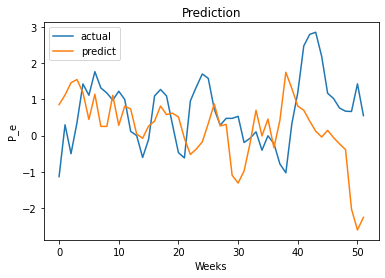

In [23]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [24]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.401


**3.Convert to binary variable**

In [25]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.135153,0.857828
1,0.298580,1.123650
2,-0.501565,1.463045
3,0.357621,1.552051
4,1.430367,1.186139


In [26]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.135153,0.857828,0,0
1,0.298580,1.123650,0,0
2,-0.501565,1.463045,0,0
3,0.357621,1.552051,0,0
4,1.430367,1.186139,0,0


In [27]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5385
When threshold = 0.02, accuracy score = 0.5385
When threshold = 0.03, accuracy score = 0.5385
When threshold = 0.04, accuracy score = 0.5385
When threshold = 0.05, accuracy score = 0.5192


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.5192
When threshold = 0.07, accuracy score = 0.5192
When threshold = 0.08, accuracy score = 0.5192
When threshold = 0.09, accuracy score = 0.4615
When threshold = 0.1, accuracy score = 0.4615
When threshold = 0.11, accuracy score = 0.4423
When threshold = 0.12, accuracy score = 0.3846
When threshold = 0.13, accuracy score = 0.3846
When threshold = 0.14, accuracy score = 0.3846
When threshold = 0.15, accuracy score = 0.3269
When threshold = 0.16, accuracy score = 0.3462
When threshold = 0.17, accuracy score = 0.3269
When threshold = 0.18, accuracy score = 0.25
When threshold = 0.19, accuracy score = 0.2692
When threshold = 0.2, accuracy score = 0.25
The best-performing threshold: 0.01


In [28]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.135153,0.857828,0,0
1,0.298580,1.123650,1,1
2,-0.501565,1.463045,-1,1
3,0.357621,1.552051,1,1
4,1.430367,1.186139,1,-1


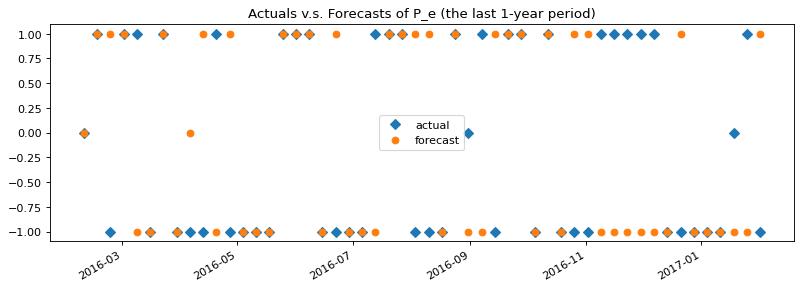

In [29]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [30]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5385


Confusion matrix

In [31]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         15  1  11   27
0           2  1   0    3
1          10  0  12   22
All        27  2  23   52

Accuracy: 0.54


Classification Report

              precision    recall  f1-score   support

          -1       0.56      0.56      0.56        27
           0       0.50      0.33      0.40         3
           1       0.52      0.55      0.53        22

    accuracy                           0.54        52
   macro avg       0.53      0.48      0.50        52
weighted avg       0.54      0.54      0.54        52



### P_i prediction

**1.Data preparation**

In [32]:
df = mcb.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.447650,0.945325,NaN,NaN
2006-02-01,0.392125,0.861850,1.045747,1.317686
2006-02-08,0.233075,0.394575,0.167531,0.292462
2006-02-15,0.448000,0.961125,0.736040,1.232916
2006-02-22,0.279925,0.585350,20.078665,48.112335
...,...,...,...,...
2017-01-04,0.378639,0.475785,0.775779,0.761705
2017-01-11,0.253141,0.305259,0.725645,0.674672
2017-01-18,0.413909,0.581147,0.639157,0.667497
2017-01-25,0.509584,0.680072,1.314741,1.431694


In [33]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [34]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [35]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [36]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

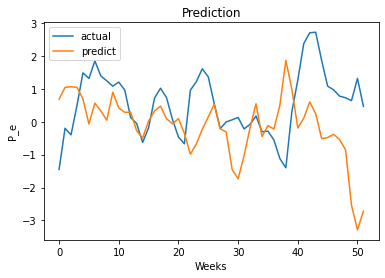

In [37]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [38]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.543


**3.Convert to binary variable**

In [39]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.450808,0.681772
1,-0.200293,1.042259
2,-0.400635,1.060230
3,0.492962,1.044323
4,1.482793,0.690670


In [40]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.450808,0.681772,0,0
1,-0.200293,1.042259,0,0
2,-0.400635,1.060230,0,0
3,0.492962,1.044323,0,0
4,1.482793,0.690670,0,0


In [41]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5577
When threshold = 0.02, accuracy score = 0.5385
When threshold = 0.03, accuracy score = 0.5385
When threshold = 0.04, accuracy score = 0.5385
When threshold = 0.05, accuracy score = 0.5385


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.5192
When threshold = 0.07, accuracy score = 0.5192
When threshold = 0.08, accuracy score = 0.5192
When threshold = 0.09, accuracy score = 0.5
When threshold = 0.1, accuracy score = 0.5
When threshold = 0.11, accuracy score = 0.4808
When threshold = 0.12, accuracy score = 0.5
When threshold = 0.13, accuracy score = 0.5
When threshold = 0.14, accuracy score = 0.4808
When threshold = 0.15, accuracy score = 0.4231
When threshold = 0.16, accuracy score = 0.3846
When threshold = 0.17, accuracy score = 0.3846
When threshold = 0.18, accuracy score = 0.3462
When threshold = 0.19, accuracy score = 0.3462
When threshold = 0.2, accuracy score = 0.3654
The best-performing threshold: 0.01


In [42]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.450808,0.681772,0,0
1,-0.200293,1.042259,1,1
2,-0.400635,1.060230,-1,1
3,0.492962,1.044323,1,-1
4,1.482793,0.690670,1,-1


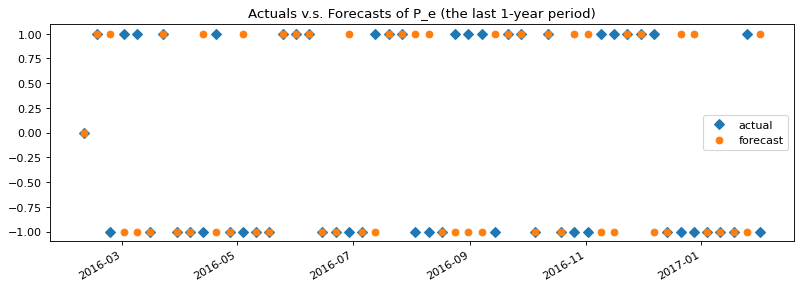

In [43]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [44]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5577


Confusion matrix

In [45]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         16  0  12   28
0           0  1   0    1
1          11  0  12   23
All        27  1  24   52

Accuracy: 0.56


Classification Report

              precision    recall  f1-score   support

          -1       0.59      0.57      0.58        28
           0       1.00      1.00      1.00         1
           1       0.50      0.52      0.51        23

    accuracy                           0.56        52
   macro avg       0.70      0.70      0.70        52
weighted avg       0.56      0.56      0.56        52



## mcg, Mid Capital Growth

### P_e prediction

**1.Data preparation**

In [46]:
df = mcg.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.883250,0.987300,NaN,NaN
2006-02-01,0.798025,1.368800,1.413000,2.186339
2006-02-08,0.805100,1.388866,0.619278,1.189829
2006-02-15,0.643625,0.964266,3.311315,1.006370
2006-02-22,0.547450,0.674316,3.393621,1.264138
...,...,...,...,...
2017-01-04,-0.311569,-0.080262,-0.150895,0.325905
2017-01-11,-0.475247,-0.448025,-0.086587,0.054559
2017-01-18,-0.262978,-0.040175,0.030480,0.220575
2017-01-25,-0.253853,-0.058425,0.697480,0.837628


In [47]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [48]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [49]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [50]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

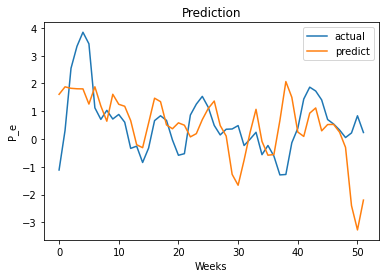

In [51]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [52]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.339


**3.Convert to binary variable**

In [53]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.112856,1.609413
1,0.310134,1.879220
2,2.546640,1.826535
3,3.338123,1.809432
4,3.843354,1.805304


In [54]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.112856,1.609413,0,0
1,0.310134,1.879220,0,0
2,2.546640,1.826535,0,0
3,3.338123,1.809432,0,0
4,3.843354,1.805304,0,0


In [55]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4231
When threshold = 0.02, accuracy score = 0.4038
When threshold = 0.03, accuracy score = 0.4038
When threshold = 0.04, accuracy score = 0.4038
When threshold = 0.05, accuracy score = 0.4038


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4038
When threshold = 0.07, accuracy score = 0.4038
When threshold = 0.08, accuracy score = 0.3846
When threshold = 0.09, accuracy score = 0.4038
When threshold = 0.1, accuracy score = 0.4038
When threshold = 0.11, accuracy score = 0.3846
When threshold = 0.12, accuracy score = 0.3654
When threshold = 0.13, accuracy score = 0.3654
When threshold = 0.14, accuracy score = 0.3462
When threshold = 0.15, accuracy score = 0.3462
When threshold = 0.16, accuracy score = 0.3654
When threshold = 0.17, accuracy score = 0.3462
When threshold = 0.18, accuracy score = 0.3654
When threshold = 0.19, accuracy score = 0.3846
When threshold = 0.2, accuracy score = 0.3846
The best-performing threshold: 0.01


In [56]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.112856,1.609413,0,0
1,0.310134,1.879220,1,1
2,2.546640,1.826535,1,-1
3,3.338123,1.809432,1,-1
4,3.843354,1.805304,1,0


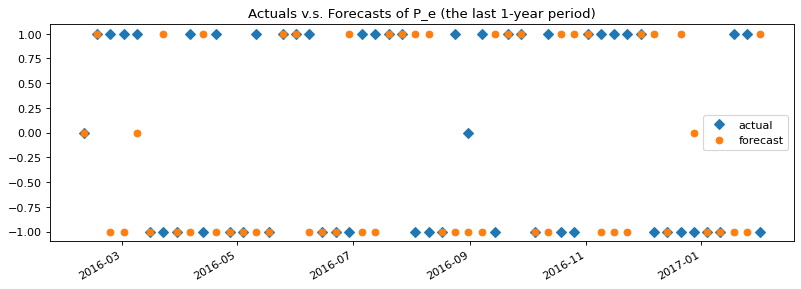

In [57]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [58]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.4231


Confusion matrix

In [59]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         12  1  11   24
0           1  1   0    2
1          16  1   9   26
All        29  3  20   52

Accuracy: 0.42


Classification Report

              precision    recall  f1-score   support

          -1       0.41      0.50      0.45        24
           0       0.33      0.50      0.40         2
           1       0.45      0.35      0.39        26

    accuracy                           0.42        52
   macro avg       0.40      0.45      0.41        52
weighted avg       0.43      0.42      0.42        52



### P_i prediction

**1.Data preparation**

In [60]:
df = mcg.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.883250,0.987300,NaN,NaN
2006-02-01,0.798025,1.368800,1.413000,2.186339
2006-02-08,0.805100,1.388866,0.619278,1.189829
2006-02-15,0.643625,0.964266,3.311315,1.006370
2006-02-22,0.547450,0.674316,3.393621,1.264138
...,...,...,...,...
2017-01-04,-0.311569,-0.080262,-0.150895,0.325905
2017-01-11,-0.475247,-0.448025,-0.086587,0.054559
2017-01-18,-0.262978,-0.040175,0.030480,0.220575
2017-01-25,-0.253853,-0.058425,0.697480,0.837628


In [61]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [62]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [63]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [64]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

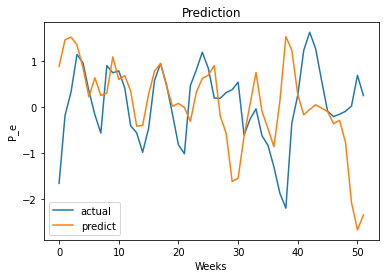

In [65]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [66]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.229


**3.Convert to binary variable**

In [67]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.657552,0.891559
1,-0.174732,1.472419
2,0.330574,1.530579
3,1.151061,1.360675
4,0.972655,0.865391


In [68]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.657552,0.891559,0,0
1,-0.174732,1.472419,0,0
2,0.330574,1.530579,0,0
3,1.151061,1.360675,0,0
4,0.972655,0.865391,0,0


In [69]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5385
When threshold = 0.02, accuracy score = 0.5385
When threshold = 0.03, accuracy score = 0.5385
When threshold = 0.04, accuracy score = 0.5385
When threshold = 0.05, accuracy score = 0.5192


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4808
When threshold = 0.07, accuracy score = 0.4615
When threshold = 0.08, accuracy score = 0.4423
When threshold = 0.09, accuracy score = 0.4231
When threshold = 0.1, accuracy score = 0.4231
When threshold = 0.11, accuracy score = 0.4231
When threshold = 0.12, accuracy score = 0.3846
When threshold = 0.13, accuracy score = 0.3846
When threshold = 0.14, accuracy score = 0.3846
When threshold = 0.15, accuracy score = 0.3654
When threshold = 0.16, accuracy score = 0.3654
When threshold = 0.17, accuracy score = 0.3654
When threshold = 0.18, accuracy score = 0.3462
When threshold = 0.19, accuracy score = 0.3462
When threshold = 0.2, accuracy score = 0.3654
The best-performing threshold: 0.01


In [70]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.657552,0.891559,0,0
1,-0.174732,1.472419,1,1
2,0.330574,1.530579,1,1
3,1.151061,1.360675,1,-1
4,0.972655,0.865391,-1,-1


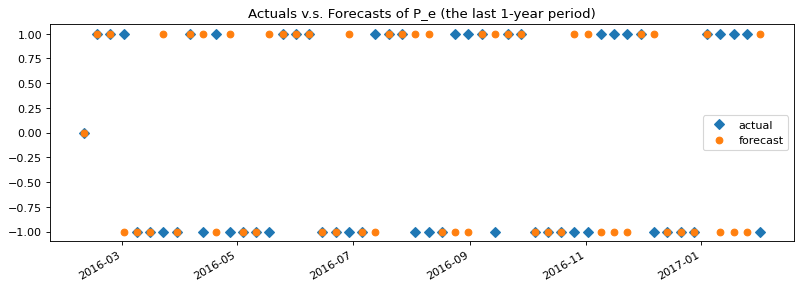

In [71]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [72]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5577


Confusion matrix

In [73]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         15  0  12   27
0           0  1   0    1
1          11  0  13   24
All        26  1  25   52

Accuracy: 0.56


Classification Report

              precision    recall  f1-score   support

          -1       0.58      0.56      0.57        27
           0       1.00      1.00      1.00         1
           1       0.52      0.54      0.53        24

    accuracy                           0.56        52
   macro avg       0.70      0.70      0.70        52
weighted avg       0.56      0.56      0.56        52



## mcv, Mid Capital Value

### P_e prediction

**1.Data preparation**

In [74]:
df = mcv.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.567325,-0.621400,NaN,NaN
2006-02-01,-1.415458,-1.847413,-1.168020,-1.672754
2006-02-08,-1.432658,-1.978963,-1.870985,-2.513026
2006-02-15,-1.342008,-1.861063,-1.319909,-1.900797
2006-02-22,-1.258058,-1.762663,-0.731408,-1.240158
...,...,...,...,...
2017-01-04,0.250756,0.740411,0.436812,0.989318
2017-01-11,0.415927,0.494739,0.668481,0.737190
2017-01-18,0.263996,0.793464,0.331137,0.812501
2017-01-25,0.234262,0.753782,0.849646,1.406675


In [75]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [76]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [77]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [78]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

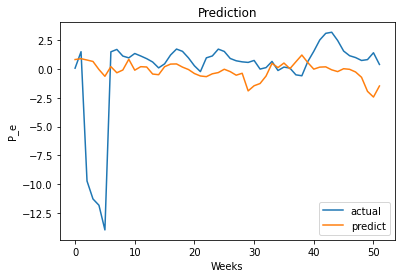

In [79]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [80]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.639


**3.Convert to binary variable**

In [81]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,0.067889,0.817335
1,1.498558,0.893479
2,-9.720792,0.776173
3,-11.278424,0.651516
4,-11.825444,-0.048144


In [82]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,0.067889,0.817335,0,0
1,1.498558,0.893479,0,0
2,-9.720792,0.776173,0,0
3,-11.278424,0.651516,0,0
4,-11.825444,-0.048144,0,0


In [83]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.6538
When threshold = 0.02, accuracy score = 0.6346
When threshold = 0.03, accuracy score = 0.5962
When threshold = 0.04, accuracy score = 0.5962
When threshold = 0.05, accuracy score = 0.5769


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.5385
When threshold = 0.07, accuracy score = 0.5385
When threshold = 0.08, accuracy score = 0.5192
When threshold = 0.09, accuracy score = 0.5192
When threshold = 0.1, accuracy score = 0.5
When threshold = 0.11, accuracy score = 0.4808
When threshold = 0.12, accuracy score = 0.4615
When threshold = 0.13, accuracy score = 0.4231
When threshold = 0.14, accuracy score = 0.4231
When threshold = 0.15, accuracy score = 0.4231
When threshold = 0.16, accuracy score = 0.4038
When threshold = 0.17, accuracy score = 0.3846
When threshold = 0.18, accuracy score = 0.3462
When threshold = 0.19, accuracy score = 0.3462
When threshold = 0.2, accuracy score = 0.3269
The best-performing threshold: 0.01


In [84]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,0.067889,0.817335,0,0
1,1.498558,0.893479,1,1
2,-9.720792,0.776173,-1,-1
3,-11.278424,0.651516,-1,-1
4,-11.825444,-0.048144,-1,-1


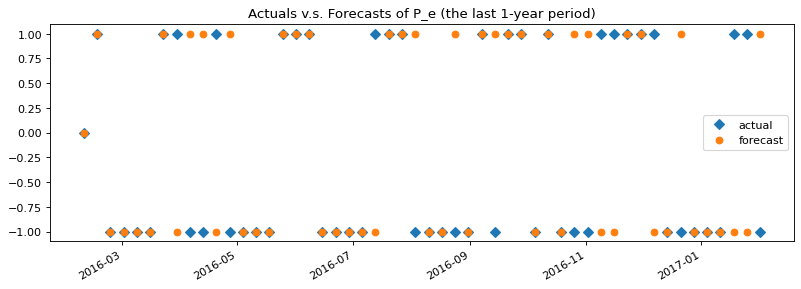

In [85]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [86]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6538


Confusion matrix

In [87]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         20  0  10   30
0           0  1   0    1
1           8  0  13   21
All        28  1  23   52

Accuracy: 0.65


Classification Report

              precision    recall  f1-score   support

          -1       0.71      0.67      0.69        30
           0       1.00      1.00      1.00         1
           1       0.57      0.62      0.59        21

    accuracy                           0.65        52
   macro avg       0.76      0.76      0.76        52
weighted avg       0.66      0.65      0.66        52



### P_i prediction

**1.Data preparation**

In [88]:
df = mcv.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.567325,-0.621400,NaN,NaN
2006-02-01,-1.415458,-1.847413,-1.168020,-1.672754
2006-02-08,-1.432658,-1.978963,-1.870985,-2.513026
2006-02-15,-1.342008,-1.861063,-1.319909,-1.900797
2006-02-22,-1.258058,-1.762663,-0.731408,-1.240158
...,...,...,...,...
2017-01-04,0.250756,0.740411,0.436812,0.989318
2017-01-11,0.415927,0.494739,0.668481,0.737190
2017-01-18,0.263996,0.793464,0.331137,0.812501
2017-01-25,0.234262,0.753782,0.849646,1.406675


In [89]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [90]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [91]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [92]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

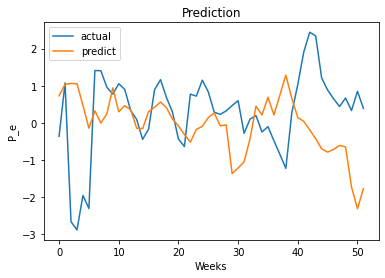

In [93]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [94]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.511


**3.Convert to binary variable**

In [95]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.365543,0.727456
1,1.073379,1.037917
2,-2.665008,1.059388
3,-2.888225,1.053352
4,-1.957494,0.470323


In [96]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.365543,0.727456,0,0
1,1.073379,1.037917,0,0
2,-2.665008,1.059388,0,0
3,-2.888225,1.053352,0,0
4,-1.957494,0.470323,0,0


In [97]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5
When threshold = 0.02, accuracy score = 0.5
When threshold = 0.03, accuracy score = 0.4808
When threshold = 0.04, accuracy score = 0.4808
When threshold = 0.05, accuracy score = 0.4808


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4615
When threshold = 0.07, accuracy score = 0.4615
When threshold = 0.08, accuracy score = 0.4615
When threshold = 0.09, accuracy score = 0.4423
When threshold = 0.1, accuracy score = 0.4038
When threshold = 0.11, accuracy score = 0.3846
When threshold = 0.12, accuracy score = 0.3654
When threshold = 0.13, accuracy score = 0.3654
When threshold = 0.14, accuracy score = 0.3462
When threshold = 0.15, accuracy score = 0.3077
When threshold = 0.16, accuracy score = 0.3077
When threshold = 0.17, accuracy score = 0.3269
When threshold = 0.18, accuracy score = 0.3269
When threshold = 0.19, accuracy score = 0.3077
When threshold = 0.2, accuracy score = 0.3077
The best-performing threshold: 0.01


In [98]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.365543,0.727456,0,0
1,1.073379,1.037917,1,1
2,-2.665008,1.059388,-1,1
3,-2.888225,1.053352,-1,-1
4,-1.957494,0.470323,1,-1


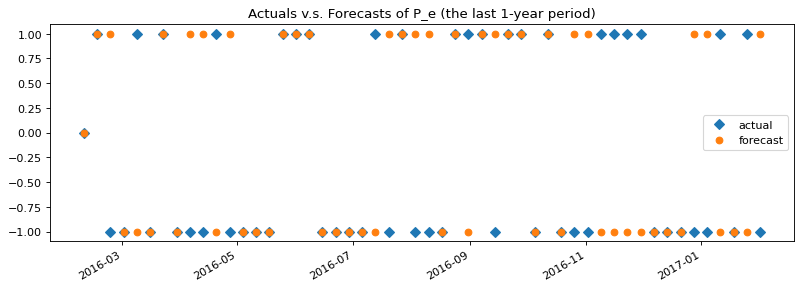

In [99]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [100]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5577


Confusion matrix

In [101]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         17  0  13   30
0           0  1   0    1
1          10  0  11   21
All        27  1  24   52

Accuracy: 0.56


Classification Report

              precision    recall  f1-score   support

          -1       0.63      0.57      0.60        30
           0       1.00      1.00      1.00         1
           1       0.46      0.52      0.49        21

    accuracy                           0.56        52
   macro avg       0.70      0.70      0.70        52
weighted avg       0.57      0.56      0.56        52



## rea, Real Estate

### P_e prediction

**1.Data preparation**

In [102]:
df = rea.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-4.778798,-2.467236,NaN,NaN
2006-02-01,4.328739,10.452508,4.733477,6.879626
2006-02-08,-6.972961,-4.202867,-7.411409,-7.499496
2006-02-15,-5.615036,-2.007417,3.515142,-5.380858
2006-02-22,1.124612,5.280494,11.187367,3.233208
...,...,...,...,...
2017-01-04,-0.200627,-0.243019,0.418418,0.590984
2017-01-11,0.129098,0.378731,0.555290,0.975551
2017-01-18,0.161098,0.271181,0.718568,1.021431
2017-01-25,0.292948,0.546681,0.893908,1.334712


In [103]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [104]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [105]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [106]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

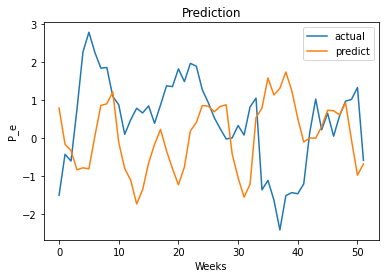

In [107]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [108]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.735


**3.Convert to binary variable**

In [109]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.500388,0.794862
1,-0.421535,-0.158998
2,-0.599315,-0.324350
3,0.762355,-0.830869
4,2.268046,-0.777505


In [110]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.500388,0.794862,0,0
1,-0.421535,-0.158998,0,0
2,-0.599315,-0.324350,0,0
3,0.762355,-0.830869,0,0
4,2.268046,-0.777505,0,0


In [111]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4423
When threshold = 0.02, accuracy score = 0.3654
When threshold = 0.03, accuracy score = 0.3462
When threshold = 0.04, accuracy score = 0.3462


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.3654
When threshold = 0.06, accuracy score = 0.3462
When threshold = 0.07, accuracy score = 0.3462
When threshold = 0.08, accuracy score = 0.3462
When threshold = 0.09, accuracy score = 0.3462
When threshold = 0.1, accuracy score = 0.3462
When threshold = 0.11, accuracy score = 0.3269
When threshold = 0.12, accuracy score = 0.3269
When threshold = 0.13, accuracy score = 0.3269
When threshold = 0.14, accuracy score = 0.3269
When threshold = 0.15, accuracy score = 0.3077
When threshold = 0.16, accuracy score = 0.3077
When threshold = 0.17, accuracy score = 0.2885
When threshold = 0.18, accuracy score = 0.3077
When threshold = 0.19, accuracy score = 0.2885
When threshold = 0.2, accuracy score = 0.2885
The best-performing threshold: 0.01


In [112]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.500388,0.794862,0,0
1,-0.421535,-0.158998,1,-1
2,-0.599315,-0.324350,-1,-1
3,0.762355,-0.830869,1,-1
4,2.268046,-0.777505,1,1


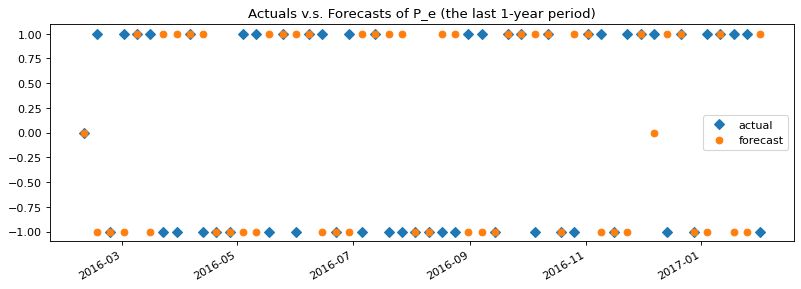

In [113]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [114]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.4423


Confusion matrix

In [115]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         10  0  14   24
0           0  1   0    1
1          14  1  12   27
All        24  2  26   52

Accuracy: 0.44


Classification Report

              precision    recall  f1-score   support

          -1       0.42      0.42      0.42        24
           0       0.50      1.00      0.67         1
           1       0.46      0.44      0.45        27

    accuracy                           0.44        52
   macro avg       0.46      0.62      0.51        52
weighted avg       0.44      0.44      0.44        52



### P_i prediction

**1.Data preparation**

In [116]:
df = rea.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-4.778798,-2.467236,NaN,NaN
2006-02-01,4.328739,10.452508,4.733477,6.879626
2006-02-08,-6.972961,-4.202867,-7.411409,-7.499496
2006-02-15,-5.615036,-2.007417,3.515142,-5.380858
2006-02-22,1.124612,5.280494,11.187367,3.233208
...,...,...,...,...
2017-01-04,-0.200627,-0.243019,0.418418,0.590984
2017-01-11,0.129098,0.378731,0.555290,0.975551
2017-01-18,0.161098,0.271181,0.718568,1.021431
2017-01-25,0.292948,0.546681,0.893908,1.334712


In [117]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [118]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [119]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [120]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

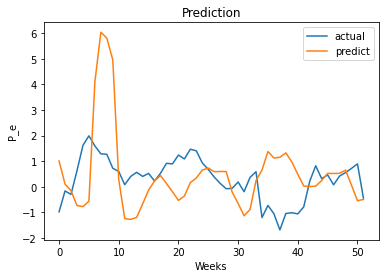

In [121]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [122]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.672


**3.Convert to binary variable**

In [123]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.975867,1.006428
1,-0.162122,0.103814
2,-0.297303,-0.153848
3,0.626919,-0.733541
4,1.617572,-0.773937


In [124]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.975867,1.006428,0,0
1,-0.162122,0.103814,0,0
2,-0.297303,-0.153848,0,0
3,0.626919,-0.733541,0,0
4,1.617572,-0.773937,0,0


In [125]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4423
When threshold = 0.02, accuracy score = 0.4038
When threshold = 0.03, accuracy score = 0.3846
When threshold = 0.04, accuracy score = 0.3846
When threshold = 0.05, accuracy score = 0.3654


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.3654
When threshold = 0.07, accuracy score = 0.3654
When threshold = 0.08, accuracy score = 0.3462
When threshold = 0.09, accuracy score = 0.3462
When threshold = 0.1, accuracy score = 0.3462
When threshold = 0.11, accuracy score = 0.3462
When threshold = 0.12, accuracy score = 0.3269
When threshold = 0.13, accuracy score = 0.2885
When threshold = 0.14, accuracy score = 0.2885
When threshold = 0.15, accuracy score = 0.25
When threshold = 0.16, accuracy score = 0.25
When threshold = 0.17, accuracy score = 0.2692
When threshold = 0.18, accuracy score = 0.2885
When threshold = 0.19, accuracy score = 0.2885
When threshold = 0.2, accuracy score = 0.2885
The best-performing threshold: 0.01


In [126]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.975867,1.006428,0,0
1,-0.162122,0.103814,1,-1
2,-0.297303,-0.153848,-1,-1
3,0.626919,-0.733541,1,-1
4,1.617572,-0.773937,1,-1


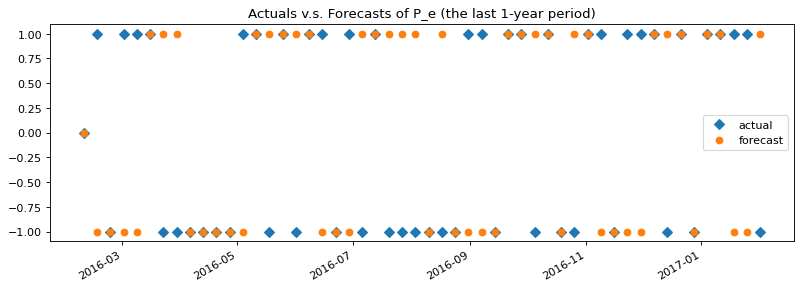

In [127]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [128]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5


Confusion matrix

In [129]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         12  0  13   25
0           0  1   0    1
1          13  0  13   26
All        25  1  26   52

Accuracy: 0.50


Classification Report

              precision    recall  f1-score   support

          -1       0.48      0.48      0.48        25
           0       1.00      1.00      1.00         1
           1       0.50      0.50      0.50        26

    accuracy                           0.50        52
   macro avg       0.66      0.66      0.66        52
weighted avg       0.50      0.50      0.50        52



## scb, Small Capital Blend

### P_e prediction

**1.Data preparation**

In [130]:
df = scb.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-1.809800,-2.205550,NaN,NaN
2006-02-01,2.196990,3.752425,3.359984,4.889245
2006-02-08,0.920090,1.606700,1.036436,1.337141
2006-02-15,0.588240,1.074850,2.848041,1.211457
2006-02-22,3.287540,5.826625,4.955672,4.918075
...,...,...,...,...
2017-01-04,0.640025,0.927800,1.072739,1.391007
2017-01-11,0.501675,0.696800,0.782335,1.001378
2017-01-18,0.551025,0.759825,0.345667,0.472856
2017-01-25,0.361532,0.385198,0.828742,0.806032


In [131]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [132]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [133]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [134]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

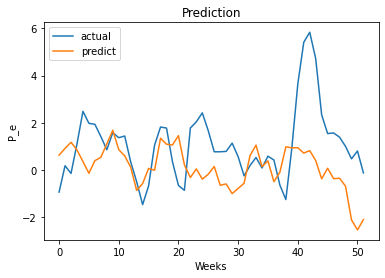

In [135]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [136]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.854


**3.Convert to binary variable**

In [137]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.936424,0.627651
1,0.180657,0.917819
2,-0.144242,1.174899
3,1.104478,0.851950
4,2.485782,0.358169


In [138]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.936424,0.627651,0,0
1,0.180657,0.917819,0,0
2,-0.144242,1.174899,0,0
3,1.104478,0.851950,0,0
4,2.485782,0.358169,0,0


In [139]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4615
When threshold = 0.02, accuracy score = 0.4423
When threshold = 0.03, accuracy score = 0.4423
When threshold = 0.04, accuracy score = 0.4231
When threshold = 0.05, accuracy score = 0.4038


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4231
When threshold = 0.07, accuracy score = 0.4231
When threshold = 0.08, accuracy score = 0.4231
When threshold = 0.09, accuracy score = 0.4231
When threshold = 0.1, accuracy score = 0.4231
When threshold = 0.11, accuracy score = 0.4038
When threshold = 0.12, accuracy score = 0.4038
When threshold = 0.13, accuracy score = 0.4038
When threshold = 0.14, accuracy score = 0.4038
When threshold = 0.15, accuracy score = 0.4038
When threshold = 0.16, accuracy score = 0.4038
When threshold = 0.17, accuracy score = 0.3846
When threshold = 0.18, accuracy score = 0.4038
When threshold = 0.19, accuracy score = 0.4038
When threshold = 0.2, accuracy score = 0.4038
The best-performing threshold: 0.01


In [140]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.936424,0.627651,0,0
1,0.180657,0.917819,1,1
2,-0.144242,1.174899,-1,1
3,1.104478,0.851950,1,-1
4,2.485782,0.358169,1,-1


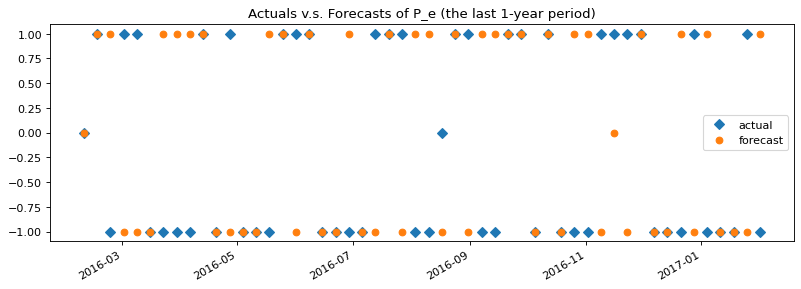

In [141]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [142]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.4615


Confusion matrix

In [143]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         13  0  15   28
0           1  1   0    2
1          11  1  10   22
All        25  2  25   52

Accuracy: 0.46


Classification Report

              precision    recall  f1-score   support

          -1       0.52      0.46      0.49        28
           0       0.50      0.50      0.50         2
           1       0.40      0.45      0.43        22

    accuracy                           0.46        52
   macro avg       0.47      0.47      0.47        52
weighted avg       0.47      0.46      0.46        52



### P_i prediction

**1.Data preparation**

In [144]:
df = scb.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-1.809800,-2.205550,NaN,NaN
2006-02-01,2.196990,3.752425,3.359984,4.889245
2006-02-08,0.920090,1.606700,1.036436,1.337141
2006-02-15,0.588240,1.074850,2.848041,1.211457
2006-02-22,3.287540,5.826625,4.955672,4.918075
...,...,...,...,...
2017-01-04,0.640025,0.927800,1.072739,1.391007
2017-01-11,0.501675,0.696800,0.782335,1.001378
2017-01-18,0.551025,0.759825,0.345667,0.472856
2017-01-25,0.361532,0.385198,0.828742,0.806032


In [145]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [146]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [147]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [148]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

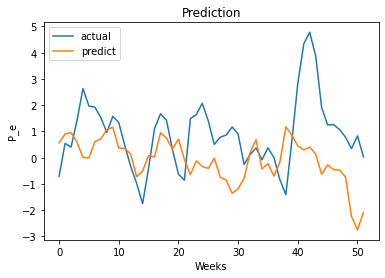

In [149]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [150]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.758


**3.Convert to binary variable**

In [151]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.714390,0.566587
1,0.544394,0.899817
2,0.403582,0.955853
3,1.407489,0.595060
4,2.636989,0.011325


In [152]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.714390,0.566587,0,0
1,0.544394,0.899817,0,0
2,0.403582,0.955853,0,0
3,1.407489,0.595060,0,0
4,2.636989,0.011325,0,0


In [153]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5
When threshold = 0.02, accuracy score = 0.4808
When threshold = 0.03, accuracy score = 0.4423
When threshold = 0.04, accuracy score = 0.4423
When threshold = 0.05, accuracy score = 0.4423


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4423
When threshold = 0.07, accuracy score = 0.4231
When threshold = 0.08, accuracy score = 0.4231
When threshold = 0.09, accuracy score = 0.4231
When threshold = 0.1, accuracy score = 0.4038
When threshold = 0.11, accuracy score = 0.3846
When threshold = 0.12, accuracy score = 0.4038
When threshold = 0.13, accuracy score = 0.4038
When threshold = 0.14, accuracy score = 0.4038
When threshold = 0.15, accuracy score = 0.4231
When threshold = 0.16, accuracy score = 0.4038
When threshold = 0.17, accuracy score = 0.4038
When threshold = 0.18, accuracy score = 0.4231
When threshold = 0.19, accuracy score = 0.4423
When threshold = 0.2, accuracy score = 0.4423
The best-performing threshold: 0.01


In [154]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.714390,0.566587,0,0
1,0.544394,0.899817,1,1
2,0.403582,0.955853,-1,1
3,1.407489,0.595060,1,-1
4,2.636989,0.011325,1,-1


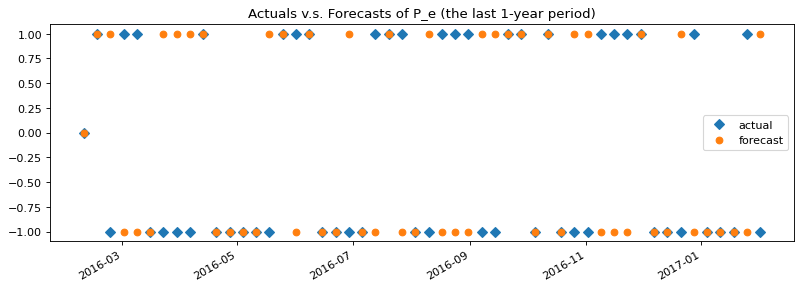

In [155]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [156]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5


Confusion matrix

In [157]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         16  0  13   29
0           0  1   0    1
1          13  0   9   22
All        29  1  22   52

Accuracy: 0.50


Classification Report

              precision    recall  f1-score   support

          -1       0.55      0.55      0.55        29
           0       1.00      1.00      1.00         1
           1       0.41      0.41      0.41        22

    accuracy                           0.50        52
   macro avg       0.65      0.65      0.65        52
weighted avg       0.50      0.50      0.50        52



## scg, Small Capital Growth

### P_e prediction

**1.Data preparation**

In [158]:
df = scg.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.245700,-0.909325,NaN,NaN
2006-02-01,-0.196125,-0.563775,1.054145,0.939570
2006-02-08,-0.184375,-0.294975,0.144634,-0.005491
2006-02-15,-0.149350,-0.359100,0.717429,0.324581
2006-02-22,0.167100,0.554875,0.826155,0.913163
...,...,...,...,...
2017-01-04,-0.080525,0.351700,0.165023,0.712404
2017-01-11,-0.109275,0.175825,0.299309,0.530150
2017-01-18,-0.037175,0.378325,0.042644,0.381932
2017-01-25,0.295303,0.781775,1.066742,1.376002


In [159]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [160]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [161]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [162]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

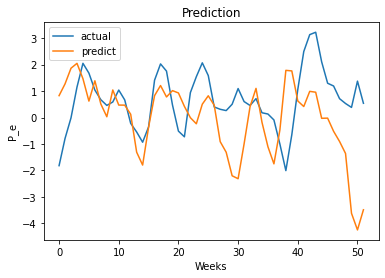

In [163]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [164]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.842


**3.Convert to binary variable**

In [165]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.821904,0.826994
1,-0.792080,1.272751
2,-0.012433,1.865399
3,1.149380,2.048922
4,2.050214,1.469211


In [166]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.821904,0.826994,0,0
1,-0.792080,1.272751,0,0
2,-0.012433,1.865399,0,0
3,1.149380,2.048922,0,0
4,2.050214,1.469211,0,0


In [167]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5962
When threshold = 0.02, accuracy score = 0.5962
When threshold = 0.03, accuracy score = 0.5962
When threshold = 0.04, accuracy score = 0.5962


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.5577
When threshold = 0.06, accuracy score = 0.5577
When threshold = 0.07, accuracy score = 0.5577
When threshold = 0.08, accuracy score = 0.5577
When threshold = 0.09, accuracy score = 0.5192
When threshold = 0.1, accuracy score = 0.5385
When threshold = 0.11, accuracy score = 0.5192
When threshold = 0.12, accuracy score = 0.5192
When threshold = 0.13, accuracy score = 0.5
When threshold = 0.14, accuracy score = 0.5
When threshold = 0.15, accuracy score = 0.4808
When threshold = 0.16, accuracy score = 0.4808
When threshold = 0.17, accuracy score = 0.4808
When threshold = 0.18, accuracy score = 0.4808
When threshold = 0.19, accuracy score = 0.4423
When threshold = 0.2, accuracy score = 0.4423
The best-performing threshold: 0.01


In [168]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.821904,0.826994,0,0
1,-0.792080,1.272751,1,1
2,-0.012433,1.865399,1,1
3,1.149380,2.048922,1,1
4,2.050214,1.469211,1,-1


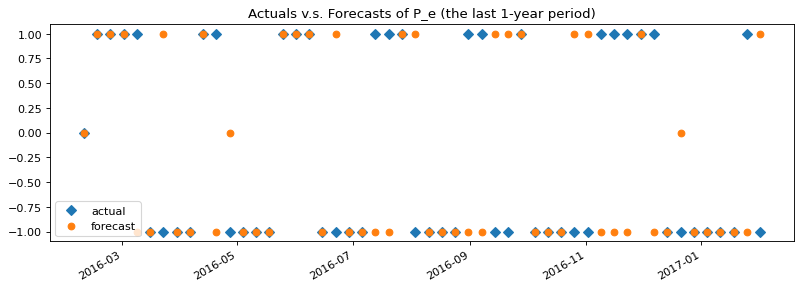

In [169]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [170]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5962


Confusion matrix

In [171]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         20  2   8   30
0           0  1   0    1
1          11  0  10   21
All        31  3  18   52

Accuracy: 0.60


Classification Report

              precision    recall  f1-score   support

          -1       0.65      0.67      0.66        30
           0       0.33      1.00      0.50         1
           1       0.56      0.48      0.51        21

    accuracy                           0.60        52
   macro avg       0.51      0.71      0.56        52
weighted avg       0.60      0.60      0.60        52



### P_i prediction

**1.Data preparation**

In [172]:
df = scg.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.245700,-0.909325,NaN,NaN
2006-02-01,-0.196125,-0.563775,1.054145,0.939570
2006-02-08,-0.184375,-0.294975,0.144634,-0.005491
2006-02-15,-0.149350,-0.359100,0.717429,0.324581
2006-02-22,0.167100,0.554875,0.826155,0.913163
...,...,...,...,...
2017-01-04,-0.080525,0.351700,0.165023,0.712404
2017-01-11,-0.109275,0.175825,0.299309,0.530150
2017-01-18,-0.037175,0.378325,0.042644,0.381932
2017-01-25,0.295303,0.781775,1.066742,1.376002


In [173]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [174]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [175]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [176]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

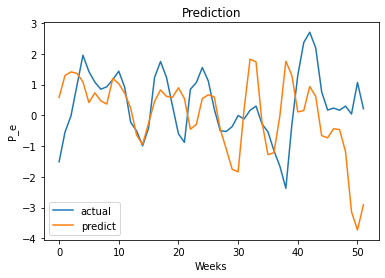

In [177]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [178]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.506


**3.Convert to binary variable**

In [179]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.511835,0.580929
1,-0.543214,1.298458
2,-0.013784,1.411142
3,0.974741,1.362870
4,1.952996,1.086769


In [180]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.511835,0.580929,0,0
1,-0.543214,1.298458,0,0
2,-0.013784,1.411142,0,0
3,0.974741,1.362870,0,0
4,1.952996,1.086769,0,0


In [181]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.6154
When threshold = 0.02, accuracy score = 0.6154
When threshold = 0.03, accuracy score = 0.5577
When threshold = 0.04, accuracy score = 0.5577
When threshold = 0.05, accuracy score = 0.5385


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.5385
When threshold = 0.07, accuracy score = 0.4808
When threshold = 0.08, accuracy score = 0.5
When threshold = 0.09, accuracy score = 0.5
When threshold = 0.1, accuracy score = 0.5
When threshold = 0.11, accuracy score = 0.5192
When threshold = 0.12, accuracy score = 0.5
When threshold = 0.13, accuracy score = 0.5
When threshold = 0.14, accuracy score = 0.5192
When threshold = 0.15, accuracy score = 0.5192
When threshold = 0.16, accuracy score = 0.5
When threshold = 0.17, accuracy score = 0.5
When threshold = 0.18, accuracy score = 0.5
When threshold = 0.19, accuracy score = 0.5
When threshold = 0.2, accuracy score = 0.5
The best-performing threshold: 0.01


In [182]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.511835,0.580929,0,0
1,-0.543214,1.298458,1,1
2,-0.013784,1.411142,1,1
3,0.974741,1.362870,1,-1
4,1.952996,1.086769,1,-1


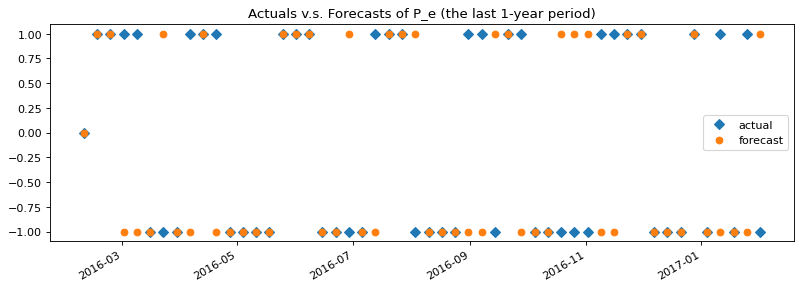

In [183]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [184]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6154


Confusion matrix

In [185]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         19  0   8   27
0           0  1   0    1
1          12  0  12   24
All        31  1  20   52

Accuracy: 0.62


Classification Report

              precision    recall  f1-score   support

          -1       0.61      0.70      0.66        27
           0       1.00      1.00      1.00         1
           1       0.60      0.50      0.55        24

    accuracy                           0.62        52
   macro avg       0.74      0.73      0.73        52
weighted avg       0.61      0.62      0.61        52



## scv, Small Capital Value

### P_e prediction

**1.Data preparation**

In [186]:
df = scv.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.256150,-0.497825,NaN,NaN
2006-02-01,-0.545500,-0.885125,0.804378,0.722841
2006-02-08,-0.324525,-0.432325,-0.008285,-0.026602
2006-02-15,-0.300500,-0.359075,0.524807,0.417535
2006-02-22,-0.170725,-0.157075,0.619083,0.524180
...,...,...,...,...
2017-01-04,0.298591,0.746166,0.808815,1.263883
2017-01-11,0.151830,0.362622,0.464205,0.648425
2017-01-18,0.331880,0.935222,0.108960,0.631623
2017-01-25,0.448330,1.172872,0.829814,1.455706


In [187]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [188]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [189]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [190]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

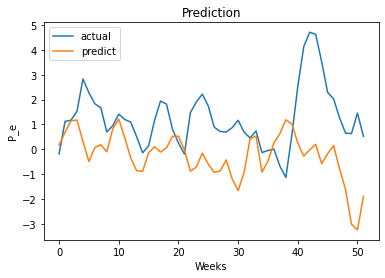

In [191]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [192]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.112


**3.Convert to binary variable**

In [193]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.188127,0.169579
1,1.122335,0.676011
2,1.169632,1.144219
3,1.528563,1.176034
4,2.829635,0.317049


In [194]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.188127,0.169579,0,0
1,1.122335,0.676011,0,0
2,1.169632,1.144219,0,0
3,1.528563,1.176034,0,0
4,2.829635,0.317049,0,0


In [195]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5385
When threshold = 0.02, accuracy score = 0.5192
When threshold = 0.03, accuracy score = 0.5192
When threshold = 0.04, accuracy score = 0.4808
When threshold = 0.05, accuracy score = 0.4615


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4423
When threshold = 0.07, accuracy score = 0.4423
When threshold = 0.08, accuracy score = 0.4423
When threshold = 0.09, accuracy score = 0.4231
When threshold = 0.1, accuracy score = 0.4231
When threshold = 0.11, accuracy score = 0.4038
When threshold = 0.12, accuracy score = 0.3846
When threshold = 0.13, accuracy score = 0.3846
When threshold = 0.14, accuracy score = 0.3846
When threshold = 0.15, accuracy score = 0.3846
When threshold = 0.16, accuracy score = 0.3846
When threshold = 0.17, accuracy score = 0.3846
When threshold = 0.18, accuracy score = 0.4231
When threshold = 0.19, accuracy score = 0.4231
When threshold = 0.2, accuracy score = 0.4231
The best-performing threshold: 0.01


In [196]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.188127,0.169579,0,0
1,1.122335,0.676011,1,1
2,1.169632,1.144219,1,1
3,1.528563,1.176034,1,1
4,2.829635,0.317049,1,-1


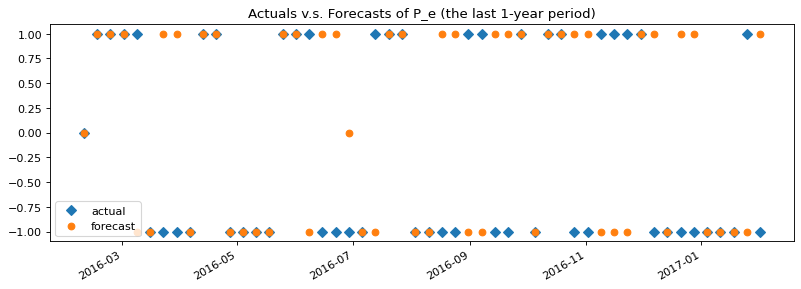

In [197]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [198]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5385


Confusion matrix

In [199]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         14  1  14   29
0           0  1   0    1
1           9  0  13   22
All        23  2  27   52

Accuracy: 0.54


Classification Report

              precision    recall  f1-score   support

          -1       0.61      0.48      0.54        29
           0       0.50      1.00      0.67         1
           1       0.48      0.59      0.53        22

    accuracy                           0.54        52
   macro avg       0.53      0.69      0.58        52
weighted avg       0.55      0.54      0.54        52



### P_i prediction

**1.Data preparation**

In [200]:
df = scv.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.256150,-0.497825,NaN,NaN
2006-02-01,-0.545500,-0.885125,0.804378,0.722841
2006-02-08,-0.324525,-0.432325,-0.008285,-0.026602
2006-02-15,-0.300500,-0.359075,0.524807,0.417535
2006-02-22,-0.170725,-0.157075,0.619083,0.524180
...,...,...,...,...
2017-01-04,0.298591,0.746166,0.808815,1.263883
2017-01-11,0.151830,0.362622,0.464205,0.648425
2017-01-18,0.331880,0.935222,0.108960,0.631623
2017-01-25,0.448330,1.172872,0.829814,1.455706


In [201]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [202]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [203]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [204]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

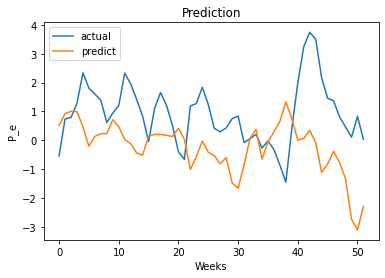

In [205]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [206]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.782


**3.Convert to binary variable**

In [207]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.539630,0.518973
1,0.738476,0.925510
2,0.795287,1.005316
3,1.280100,0.994083
4,2.338100,0.466126


In [208]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.539630,0.518973,0,0
1,0.738476,0.925510,0,0
2,0.795287,1.005316,0,0
3,1.280100,0.994083,0,0
4,2.338100,0.466126,0,0


In [209]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5577
When threshold = 0.02, accuracy score = 0.5577
When threshold = 0.03, accuracy score = 0.5385
When threshold = 0.04, accuracy score = 0.5385
When threshold = 0.05, accuracy score = 0.5192


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.5
When threshold = 0.07, accuracy score = 0.4615
When threshold = 0.08, accuracy score = 0.4615
When threshold = 0.09, accuracy score = 0.4423
When threshold = 0.1, accuracy score = 0.4423
When threshold = 0.11, accuracy score = 0.4423
When threshold = 0.12, accuracy score = 0.4231
When threshold = 0.13, accuracy score = 0.4038
When threshold = 0.14, accuracy score = 0.3846
When threshold = 0.15, accuracy score = 0.3269
When threshold = 0.16, accuracy score = 0.3269
When threshold = 0.17, accuracy score = 0.3269
When threshold = 0.18, accuracy score = 0.3269
When threshold = 0.19, accuracy score = 0.3462
When threshold = 0.2, accuracy score = 0.3462
The best-performing threshold: 0.01


In [210]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.539630,0.518973,0,0
1,0.738476,0.925510,1,1
2,0.795287,1.005316,1,1
3,1.280100,0.994083,1,-1
4,2.338100,0.466126,1,-1


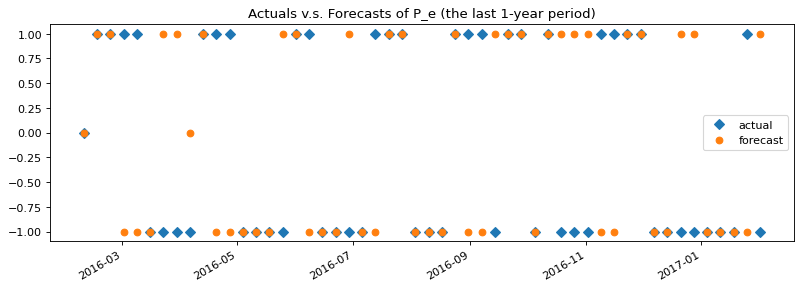

In [211]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [212]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5577


Confusion matrix

In [213]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         16  1  11   28
0           0  1   0    1
1          11  0  12   23
All        27  2  23   52

Accuracy: 0.56


Classification Report

              precision    recall  f1-score   support

          -1       0.59      0.57      0.58        28
           0       0.50      1.00      0.67         1
           1       0.52      0.52      0.52        23

    accuracy                           0.56        52
   macro avg       0.54      0.70      0.59        52
weighted avg       0.56      0.56      0.56        52



## tec, Technology

### P_e prediction

**1.Data preparation**

In [214]:
df = tec.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-4.669523,0.301250,NaN,NaN
2006-02-01,-0.035400,-0.051050,0.530734,0.517555
2006-02-08,-0.344775,-0.394125,-1.037968,-1.085868
2006-02-15,-0.790025,-0.861150,-0.775331,-0.841413
2006-02-22,0.244525,0.217125,21.571469,22.700986
...,...,...,...,...
2017-01-04,0.605800,0.654025,0.932049,0.986961
2017-01-11,0.589475,0.644175,1.104699,1.151275
2017-01-18,0.367352,0.409167,0.762911,0.792015
2017-01-25,0.650972,0.707837,1.855667,1.900845


In [215]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [216]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [217]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [218]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

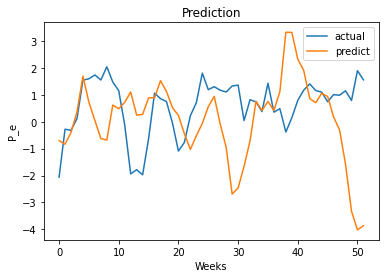

In [219]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [220]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.019


**3.Convert to binary variable**

In [221]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-2.061706,-0.700681
1,-0.278364,-0.837480
2,-0.317719,-0.399841
3,0.119180,0.365961
4,1.547012,1.695389


In [222]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-2.061706,-0.700681,0,0
1,-0.278364,-0.837480,0,0
2,-0.317719,-0.399841,0,0
3,0.119180,0.365961,0,0
4,1.547012,1.695389,0,0


In [223]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4615
When threshold = 0.02, accuracy score = 0.4615
When threshold = 0.03, accuracy score = 0.4423
When threshold = 0.04, accuracy score = 0.4231
When threshold = 0.05, accuracy score = 0.4231
When threshold = 0.06, accuracy score = 0.4231


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.07, accuracy score = 0.4038
When threshold = 0.08, accuracy score = 0.4038
When threshold = 0.09, accuracy score = 0.4038
When threshold = 0.1, accuracy score = 0.4038
When threshold = 0.11, accuracy score = 0.3654
When threshold = 0.12, accuracy score = 0.3462
When threshold = 0.13, accuracy score = 0.3269
When threshold = 0.14, accuracy score = 0.2885
When threshold = 0.15, accuracy score = 0.2885
When threshold = 0.16, accuracy score = 0.2692
When threshold = 0.17, accuracy score = 0.2692
When threshold = 0.18, accuracy score = 0.2692
When threshold = 0.19, accuracy score = 0.2692
When threshold = 0.2, accuracy score = 0.2692
The best-performing threshold: 0.01


In [224]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-2.061706,-0.700681,0,0
1,-0.278364,-0.837480,1,-1
2,-0.317719,-0.399841,-1,1
3,0.119180,0.365961,1,1
4,1.547012,1.695389,1,1


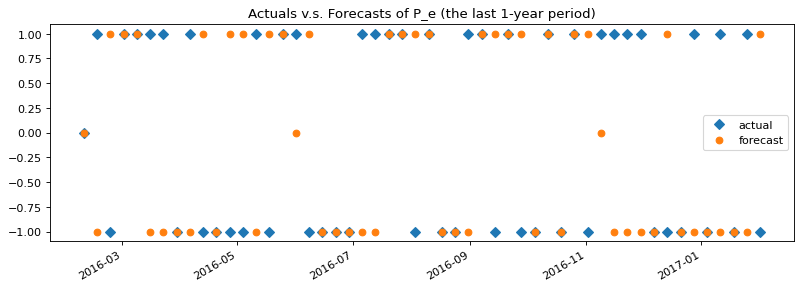

In [225]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [226]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.4615


Confusion matrix

In [227]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         13  0  12   25
0           0  1   0    1
1          14  2  10   26
All        27  3  22   52

Accuracy: 0.46


Classification Report

              precision    recall  f1-score   support

          -1       0.48      0.52      0.50        25
           0       0.33      1.00      0.50         1
           1       0.45      0.38      0.42        26

    accuracy                           0.46        52
   macro avg       0.42      0.63      0.47        52
weighted avg       0.47      0.46      0.46        52



### P_i prediction

**1.Data preparation**

In [228]:
df = tec.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-4.669523,0.301250,NaN,NaN
2006-02-01,-0.035400,-0.051050,0.530734,0.517555
2006-02-08,-0.344775,-0.394125,-1.037968,-1.085868
2006-02-15,-0.790025,-0.861150,-0.775331,-0.841413
2006-02-22,0.244525,0.217125,21.571469,22.700986
...,...,...,...,...
2017-01-04,0.605800,0.654025,0.932049,0.986961
2017-01-11,0.589475,0.644175,1.104699,1.151275
2017-01-18,0.367352,0.409167,0.762911,0.792015
2017-01-25,0.650972,0.707837,1.855667,1.900845


In [229]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [230]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [231]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [232]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

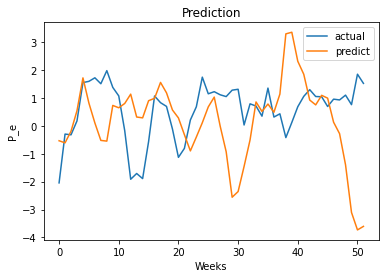

In [233]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [234]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.932


**3.Convert to binary variable**

In [235]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-2.043858,-0.531919
1,-0.292972,-0.607315
2,-0.318766,-0.191896
3,0.179139,0.544604
4,1.554973,1.723480


In [236]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-2.043858,-0.531919,0,0
1,-0.292972,-0.607315,0,0
2,-0.318766,-0.191896,0,0
3,0.179139,0.544604,0,0
4,1.554973,1.723480,0,0


In [237]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5192
When threshold = 0.02, accuracy score = 0.5192
When threshold = 0.03, accuracy score = 0.5
When threshold = 0.04, accuracy score = 0.4615
When threshold = 0.05, accuracy score = 0.4615


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4423
When threshold = 0.07, accuracy score = 0.4231
When threshold = 0.08, accuracy score = 0.4038
When threshold = 0.09, accuracy score = 0.3654
When threshold = 0.1, accuracy score = 0.3654
When threshold = 0.11, accuracy score = 0.3462
When threshold = 0.12, accuracy score = 0.3077
When threshold = 0.13, accuracy score = 0.3077
When threshold = 0.14, accuracy score = 0.2885
When threshold = 0.15, accuracy score = 0.2885
When threshold = 0.16, accuracy score = 0.2885
When threshold = 0.17, accuracy score = 0.2885
When threshold = 0.18, accuracy score = 0.2692
When threshold = 0.19, accuracy score = 0.2885
When threshold = 0.2, accuracy score = 0.2885
The best-performing threshold: 0.01


In [238]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-2.043858,-0.531919,0,0
1,-0.292972,-0.607315,1,-1
2,-0.318766,-0.191896,-1,1
3,0.179139,0.544604,1,1
4,1.554973,1.723480,1,1


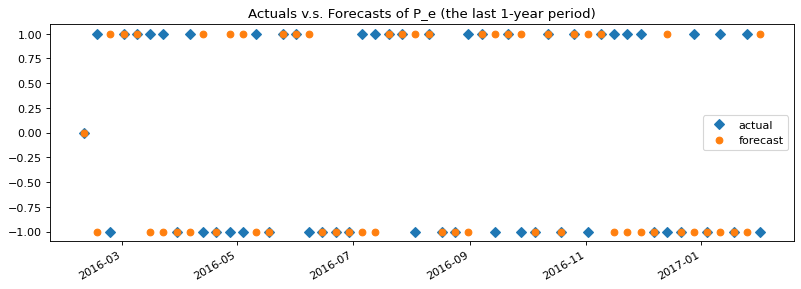

In [239]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [240]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5192


Confusion matrix

In [241]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         14  0  11   25
0           0  1   0    1
1          14  0  12   26
All        28  1  23   52

Accuracy: 0.52


Classification Report

              precision    recall  f1-score   support

          -1       0.50      0.56      0.53        25
           0       1.00      1.00      1.00         1
           1       0.52      0.46      0.49        26

    accuracy                           0.52        52
   macro avg       0.67      0.67      0.67        52
weighted avg       0.52      0.52      0.52        52



## tel, Telecom

### P_e prediction

**1.Data preparation**

In [242]:
df = tel.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.065150,0.065150,NaN,NaN
2006-02-01,0.182875,0.182875,0.876425,0.876425
2006-02-08,-0.163500,-0.163500,0.422974,0.422974
2006-02-15,-2.034750,-2.034750,-0.175601,-0.175601
2006-02-22,-2.564875,-2.564875,1.232011,1.232011
...,...,...,...,...
2017-01-04,2.968491,2.968491,4.652557,4.652557
2017-01-11,3.933241,3.933241,4.826510,4.826510
2017-01-18,3.802041,3.802041,3.851071,3.851071
2017-01-25,2.621216,2.621216,2.299940,2.299940


In [243]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [244]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [245]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [246]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

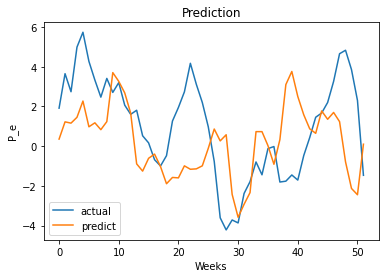

In [247]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [248]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.777


**3.Convert to binary variable**

In [249]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,1.911943,0.354373
1,3.647088,1.223152
2,2.739283,1.158039
3,4.984640,1.452084
4,5.733489,2.269998


In [250]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,1.911943,0.354373,0,0
1,3.647088,1.223152,0,0
2,2.739283,1.158039,0,0
3,4.984640,1.452084,0,0
4,5.733489,2.269998,0,0


In [251]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5
When threshold = 0.02, accuracy score = 0.5
When threshold = 0.03, accuracy score = 0.5
When threshold = 0.04, accuracy score = 0.5
When threshold = 0.05, accuracy score = 0.4808


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4808
When threshold = 0.07, accuracy score = 0.4615
When threshold = 0.08, accuracy score = 0.4615
When threshold = 0.09, accuracy score = 0.4615
When threshold = 0.1, accuracy score = 0.4615
When threshold = 0.11, accuracy score = 0.4615
When threshold = 0.12, accuracy score = 0.4615
When threshold = 0.13, accuracy score = 0.4615
When threshold = 0.14, accuracy score = 0.4615
When threshold = 0.15, accuracy score = 0.4423
When threshold = 0.16, accuracy score = 0.4423
When threshold = 0.17, accuracy score = 0.4423
When threshold = 0.18, accuracy score = 0.4423
When threshold = 0.19, accuracy score = 0.4423
When threshold = 0.2, accuracy score = 0.4423
The best-performing threshold: 0.01


In [252]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,1.911943,0.354373,0,0
1,3.647088,1.223152,1,1
2,2.739283,1.158039,-1,-1
3,4.984640,1.452084,1,1
4,5.733489,2.269998,1,1


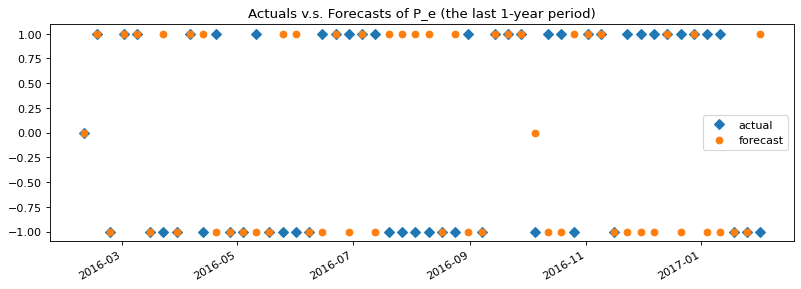

In [253]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [254]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5


Confusion matrix

In [255]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         12  1  11   24
0           0  1   0    1
1          14  0  13   27
All        26  2  24   52

Accuracy: 0.50


Classification Report

              precision    recall  f1-score   support

          -1       0.46      0.50      0.48        24
           0       0.50      1.00      0.67         1
           1       0.54      0.48      0.51        27

    accuracy                           0.50        52
   macro avg       0.50      0.66      0.55        52
weighted avg       0.50      0.50      0.50        52



### P_i prediction

**1.Data preparation**

In [256]:
df = tel.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.065150,0.065150,NaN,NaN
2006-02-01,0.182875,0.182875,0.876425,0.876425
2006-02-08,-0.163500,-0.163500,0.422974,0.422974
2006-02-15,-2.034750,-2.034750,-0.175601,-0.175601
2006-02-22,-2.564875,-2.564875,1.232011,1.232011
...,...,...,...,...
2017-01-04,2.968491,2.968491,4.652557,4.652557
2017-01-11,3.933241,3.933241,4.826510,4.826510
2017-01-18,3.802041,3.802041,3.851071,3.851071
2017-01-25,2.621216,2.621216,2.299940,2.299940


In [257]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [258]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [259]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [260]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

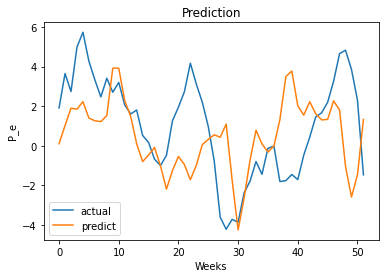

In [261]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [262]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.752


**3.Convert to binary variable**

In [263]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,1.911943,0.102482
1,3.647088,1.021955
2,2.739283,1.898114
3,4.984640,1.846854
4,5.733489,2.226983


In [264]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,1.911943,0.102482,0,0
1,3.647088,1.021955,0,0
2,2.739283,1.898114,0,0
3,4.984640,1.846854,0,0
4,5.733489,2.226983,0,0


In [265]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5192
When threshold = 0.02, accuracy score = 0.5192
When threshold = 0.03, accuracy score = 0.5
When threshold = 0.04, accuracy score = 0.5
When threshold = 0.05, accuracy score = 0.4615


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4615
When threshold = 0.07, accuracy score = 0.4615
When threshold = 0.08, accuracy score = 0.4615
When threshold = 0.09, accuracy score = 0.4615
When threshold = 0.1, accuracy score = 0.4615
When threshold = 0.11, accuracy score = 0.4423
When threshold = 0.12, accuracy score = 0.4423
When threshold = 0.13, accuracy score = 0.4231
When threshold = 0.14, accuracy score = 0.4038
When threshold = 0.15, accuracy score = 0.3846
When threshold = 0.16, accuracy score = 0.3846
When threshold = 0.17, accuracy score = 0.3846
When threshold = 0.18, accuracy score = 0.3846
When threshold = 0.19, accuracy score = 0.3846
When threshold = 0.2, accuracy score = 0.3846
The best-performing threshold: 0.01


In [266]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,1.911943,0.102482,0,0
1,3.647088,1.021955,1,1
2,2.739283,1.898114,-1,1
3,4.984640,1.846854,1,-1
4,5.733489,2.226983,1,1


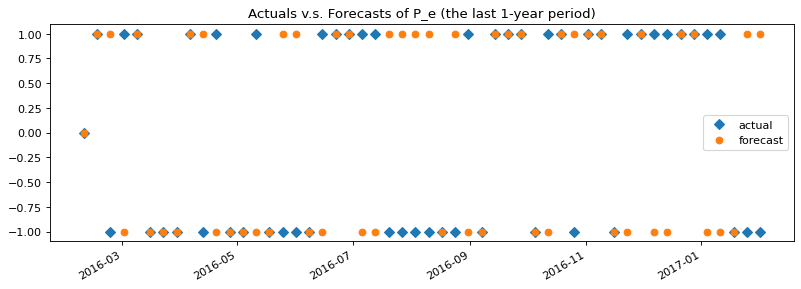

In [267]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [268]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5192


Confusion matrix

In [269]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         12  0  12   24
0           0  1   0    1
1          13  0  14   27
All        25  1  26   52

Accuracy: 0.52


Classification Report

              precision    recall  f1-score   support

          -1       0.48      0.50      0.49        24
           0       1.00      1.00      1.00         1
           1       0.54      0.52      0.53        27

    accuracy                           0.52        52
   macro avg       0.67      0.67      0.67        52
weighted avg       0.52      0.52      0.52        52



## uti, Utilities

### P_e prediction

**1.Data preparation**

In [270]:
df = uti.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.357775,0.991100,NaN,NaN
2006-02-01,0.082700,0.135250,0.446808,0.292346
2006-02-08,-0.230750,-0.924350,-0.302933,-1.039729
2006-02-15,-0.175675,-0.924350,-0.664677,-1.464150
2006-02-22,0.174300,-0.414150,28.455795,89.312702
...,...,...,...,...
2017-01-04,0.000827,0.037953,0.721468,0.720163
2017-01-11,-0.032598,-0.011147,0.429057,0.360878
2017-01-18,-0.472273,-0.579872,-0.115008,-0.298638
2017-01-25,-0.711648,-0.899847,-0.443012,-0.764663


In [271]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [272]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [273]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [274]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

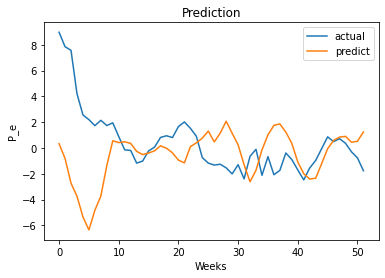

In [275]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [276]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.597


**3.Convert to binary variable**

In [277]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,8.965257,0.330959
1,7.846528,-0.808344
2,7.565747,-2.725142
3,4.209394,-3.735881
4,2.557029,-5.340650


In [278]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,8.965257,0.330959,0,0
1,7.846528,-0.808344,0,0
2,7.565747,-2.725142,0,0
3,4.209394,-3.735881,0,0
4,2.557029,-5.340650,0,0


In [279]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5769
When threshold = 0.02, accuracy score = 0.5769
When threshold = 0.03, accuracy score = 0.5769
When threshold = 0.04, accuracy score = 0.5769
When threshold = 0.05, accuracy score = 0.5769


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.5577
When threshold = 0.07, accuracy score = 0.5192
When threshold = 0.08, accuracy score = 0.5192
When threshold = 0.09, accuracy score = 0.5192
When threshold = 0.1, accuracy score = 0.5192
When threshold = 0.11, accuracy score = 0.5
When threshold = 0.12, accuracy score = 0.5
When threshold = 0.13, accuracy score = 0.5
When threshold = 0.14, accuracy score = 0.4808
When threshold = 0.15, accuracy score = 0.4615
When threshold = 0.16, accuracy score = 0.4423
When threshold = 0.17, accuracy score = 0.4231
When threshold = 0.18, accuracy score = 0.4231
When threshold = 0.19, accuracy score = 0.4423
When threshold = 0.2, accuracy score = 0.4423
The best-performing threshold: 0.01


In [280]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,8.965257,0.330959,0,0
1,7.846528,-0.808344,-1,-1
2,7.565747,-2.725142,-1,-1
3,4.209394,-3.735881,-1,-1
4,2.557029,-5.340650,-1,-1


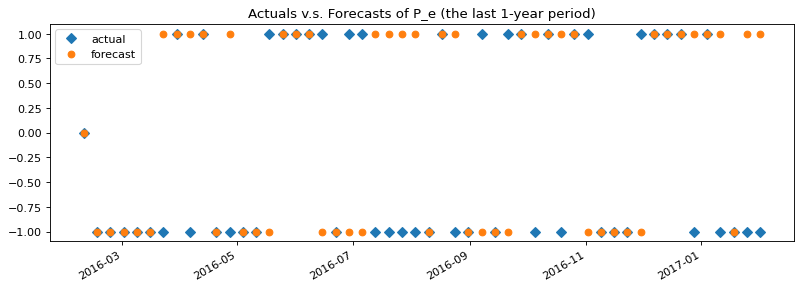

In [281]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [282]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5769


Confusion matrix

In [283]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         16  0  14   30
0           0  1   0    1
1           8  0  13   21
All        24  1  27   52

Accuracy: 0.58


Classification Report

              precision    recall  f1-score   support

          -1       0.67      0.53      0.59        30
           0       1.00      1.00      1.00         1
           1       0.48      0.62      0.54        21

    accuracy                           0.58        52
   macro avg       0.72      0.72      0.71        52
weighted avg       0.60      0.58      0.58        52



### P_i prediction

**1.Data preparation**

In [284]:
df = uti.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.357775,0.991100,NaN,NaN
2006-02-01,0.082700,0.135250,0.446808,0.292346
2006-02-08,-0.230750,-0.924350,-0.302933,-1.039729
2006-02-15,-0.175675,-0.924350,-0.664677,-1.464150
2006-02-22,0.174300,-0.414150,28.455795,89.312702
...,...,...,...,...
2017-01-04,0.000827,0.037953,0.721468,0.720163
2017-01-11,-0.032598,-0.011147,0.429057,0.360878
2017-01-18,-0.472273,-0.579872,-0.115008,-0.298638
2017-01-25,-0.711648,-0.899847,-0.443012,-0.764663


In [285]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [286]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [287]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [288]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

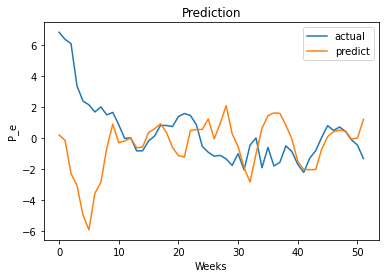

In [289]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [290]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.007


**3.Convert to binary variable**

In [291]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,6.822350,0.203273
1,6.365921,-0.138793
2,6.091387,-2.277777
3,3.376231,-3.049623
4,2.391175,-4.934412


In [292]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,6.822350,0.203273,0,0
1,6.365921,-0.138793,0,0
2,6.091387,-2.277777,0,0
3,3.376231,-3.049623,0,0
4,2.391175,-4.934412,0,0


In [293]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5769
When threshold = 0.02, accuracy score = 0.5577
When threshold = 0.03, accuracy score = 0.5577
When threshold = 0.04, accuracy score = 0.5577
When threshold = 0.05, accuracy score = 0.5385


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.5385
When threshold = 0.07, accuracy score = 0.5192
When threshold = 0.08, accuracy score = 0.5
When threshold = 0.09, accuracy score = 0.5
When threshold = 0.1, accuracy score = 0.5
When threshold = 0.11, accuracy score = 0.4808
When threshold = 0.12, accuracy score = 0.4808
When threshold = 0.13, accuracy score = 0.4808
When threshold = 0.14, accuracy score = 0.4808
When threshold = 0.15, accuracy score = 0.4808
When threshold = 0.16, accuracy score = 0.4615
When threshold = 0.17, accuracy score = 0.4615
When threshold = 0.18, accuracy score = 0.4615
When threshold = 0.19, accuracy score = 0.4808
When threshold = 0.2, accuracy score = 0.5
The best-performing threshold: 0.01


In [294]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,6.822350,0.203273,0,0
1,6.365921,-0.138793,-1,-1
2,6.091387,-2.277777,-1,-1
3,3.376231,-3.049623,-1,-1
4,2.391175,-4.934412,-1,-1


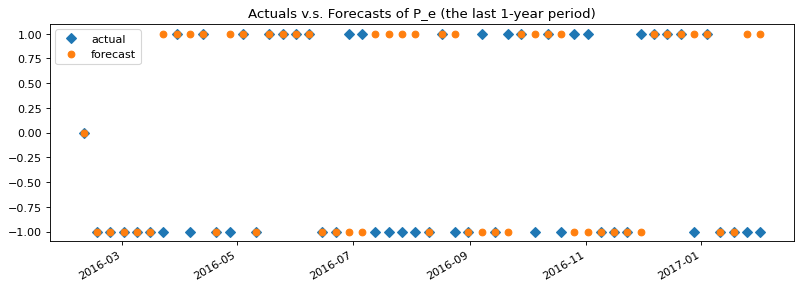

In [295]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [296]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6154


Confusion matrix

In [297]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         17  0  13   30
0           0  1   0    1
1           7  0  14   21
All        24  1  27   52

Accuracy: 0.62


Classification Report

              precision    recall  f1-score   support

          -1       0.71      0.57      0.63        30
           0       1.00      1.00      1.00         1
           1       0.52      0.67      0.58        21

    accuracy                           0.62        52
   macro avg       0.74      0.74      0.74        52
weighted avg       0.64      0.62      0.62        52



# (To the bottom)